## Figure of pool timeseries

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import warnings
warnings.filterwarnings('ignore')

In [2]:
def findBottInd(hfac):
    
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    return BottomInd

def ConcAreaShelf(Tr, hfac, ra, bathy):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx). 
       Conc = cocetration near bottom (nt,ny,nx)
       Area = 2D array of cell areas on shelf (ny,nx)
       NOTE: Everything below the canyon rim is masked out'''
    
    sh = np.shape(Tr)
    nx = sh[3]
    ny = sh[2]
    nz = sh[1]
    nt = sh[0]
    
    ConcArea = np.empty((nt,ny,nx))
    Conc = np.empty((nt,ny,nx))
    ConcFiltered = np.empty((nt,ny,nx))
    Area = np.empty((nt,ny,nx))
    
    BottomInd = findBottInd(hfac)  
    
    for tt in range(nt):
        for j in range(nx):
            for i in range(ny):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[tt,i,j] = ra[i,j]
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = np.ma.masked_invalid(ConcFiltered) 
    
    return (np.ma.masked_invalid(ConcArea),
            np.ma.masked_invalid(ConcFiltered),
            np.ma.masked_invalid(Area))

def ConcAreaPool(Tr, hfac, ra, bathy):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx). 
       Conc = cocetration near bottom (nt,ny,nx)
       Area = 2D array of cell areas on shelf (ny,nx)
       NOTE: Everything below the canyon rim is masked out'''
    
    sh = np.shape(Tr)
    nx = sh[3]
    ny = sh[2]
    nz = sh[1]
    nt = sh[0]
    
    ConcArea = np.empty((nt,ny,nx))
    Conc = np.empty((nt,ny,nx))
    ConcFiltered = np.empty((nt,ny,nx))
    Area = np.empty((nt,ny,nx))
    
    BottomInd = findBottInd(hfac)  
    
    for tt in range(nt):
        for j in range(nx):
            for i in range(ny):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = np.ma.masked_invalid(ConcFiltered) 
    
    return (np.ma.masked_invalid(ConcArea),
            np.ma.masked_invalid(ConcFiltered),
            np.ma.masked_invalid(Area))

In [3]:
def PlotAnomTimeSeries(gs_ax,ConcFilt,Area,ConcFiltNoC,AreaNoC,color='black',label='base'):
    
    ax = plt.subplot(gs_ax)
    BACpool = np.nansum(np.nansum(np.ma.masked_array((ConcFilt*Area),mask=maskExpandSB[:,yslice_bac,xslice_bac]),axis=1),axis=1)
    BACNoC = np.nansum(np.nansum(np.ma.masked_array((ConcFiltNoC*AreaNoC),mask=maskExpandSB[:,yslice_bac,xslice_bac]),axis=1),axis=1)
    
    ax.plot(np.arange(len(BACpool))/2,(BACpool*100)/BACNoC,'-',
            color = sns.xkcd_rgb[color],
            linewidth = 1,label=label)
    
    #ax.axvline(x=8,color = 'k',linestyle = '--')
    
    labels.append(label)
    
    return ax
    

In [4]:
import canyon_records 
import nocanyon_records

In [5]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [6]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

grid_fileNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
gridNoC = xr.open_dataset(grid_fileNoC)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc'
ptracersNoC = xr.open_dataset(ptracersNoC_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [7]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xslice=slice(100,360)
yslice=slice(120,310)

tslice = slice(8,16)

xind = 240
yind = 267 # y index for alongshore cross-section
zind = 27

zslice = slice(10,22)
# plot2
zslice_2 = slice(10,32)
# plot 3
yslice_bac = slice(227,300)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

hFacmaskedNoC = np.ma.masked_values(gridNoC.HFacC.data, 0)
MaskCNoC = np.ma.getmask(hFacmaskedNoC)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape)    

In [8]:
BottInd = findBottInd(grid.HFacC.data)
BottIndNoC = findBottInd(gridNoC.HFacC.data)

In [9]:
# Find mask shelf bottom

hold_maskSB = np.empty((ny,nx))

for j in range (nx):
    for i in range(ny):
        if  abs(BottInd[i,j]-BottIndNoC[i,j]) <= 1:
            hold_maskSB[i,j] = 1
        else:
            hold_maskSB[i,j]= 0
    
maskSB = np.ma.masked_equal(hold_maskSB,0)     
bathyMasked = np.ma.masked_less(-gridNoC.Depth, -152.5)

MASK_SB = np.ma.mask_or(bathyMasked.mask, maskSB.mask)

maskExpandSB = np.expand_dims(MASK_SB,0) 
maskExpandSB = maskExpandSB + np.zeros((nt,ny,nx))   


In [10]:
for ii in range(len(records)):
    print(ii,records[ii].name)

0 CNTDIFF_run61
1 CNTDIFF_run38
2 CNTDIFF_run62
3 CNTDIFF_run63
4 CNTDIFF_run45
5 CNTDIFF_run73
6 CNTDIFF_run75
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
11 3DDIFF_run04
12 3DDIFF_run05
13 3DDIFF_run06
14 3DDIFF_run07
15 LOWER_BF_run01


done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations


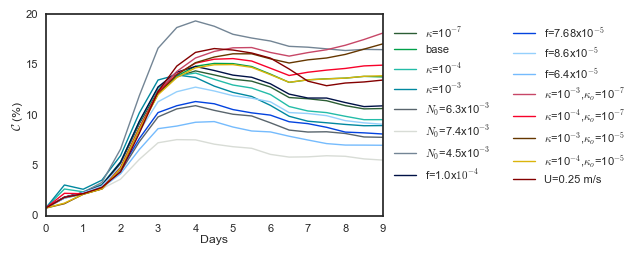

In [12]:
records2 = [records[0],
            records[2],
            #records[3],
            #records[14],
            #records[15],
            #records[16],
            #records[17],
            #records[1],
            ]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[2],
               #recordsNoC[3],
               #recordsNoC[14],
               #recordsNoC[15],
               #recordsNoC[16],
               #recordsNoC[17],
               #recordsNoC[1],
               ]

cmap_name = cmo.cm.balance
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,4.6)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(1, 1, height_ratios=[1,1], width_ratios=[1,1])

labels=[]

for rec,recNoC in zip(records,recordsNoC):
    
    ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers = xr.open_dataset(ptracers_file)

    ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    ptracersNoC = xr.open_dataset(ptracersNoC_file)

    ConcAreaWeighted, ConcFilt, Area = ConcAreaPool(ptracers.Tr1.data[:,:,yslice_bac,xslice_bac]-ptracersNoC.Tr1.data[:,:,yslice_bac,xslice_bac], 
                                                     grid.HFacC.data[:,yslice_bac,xslice_bac], 
                                                     grid.rA.data[yslice_bac,xslice_bac],
                                                     grid.Depth.data[yslice_bac,xslice_bac])

    ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC = ConcAreaShelf(ptracersNoC.Tr1.data[:,:,yslice_bac,xslice_bac],
                                                              gridNoC.HFacC.data[:,yslice_bac,xslice_bac], 
                                                              gridNoC.rA.data[yslice_bac,xslice_bac], 
                                                              gridNoC.Depth.data[yslice_bac,xslice_bac])
    print('done getting bottom concentrations')
    
    ax1=PlotAnomTimeSeries(gs0[0,0],ConcFilt,Area,ConcFiltNoC,AreaNoC,
                           color=rec.color,
                           label=rec.label)

    #ax2=PlotAnomTimeSeries(gs0[1],np.ma.masked_array(ConcFilt-ConcFiltNoC,mask=maskExpandSB),
    #          xslice,yslice_bac,250,267,color=rec.color,label=rec.label)


ax1.set_ylabel('$\mathcal{C}$ (%)',labelpad=0.3)

#ax2.set_ylabel('Area-weighted Bottom Concentration (Mol/L)',labelpad=0.3)
ax1.set_xlabel('Days',labelpad=0.3)

plt.legend(labels,bbox_to_anchor=(1.75,1),ncol=2)
   
plt.tight_layout()

plt.savefig('fig_PoolTimeSeries.pdf',format='pdf')
